In [13]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import random
import seaborn as sns
from matplotlib import gridspec

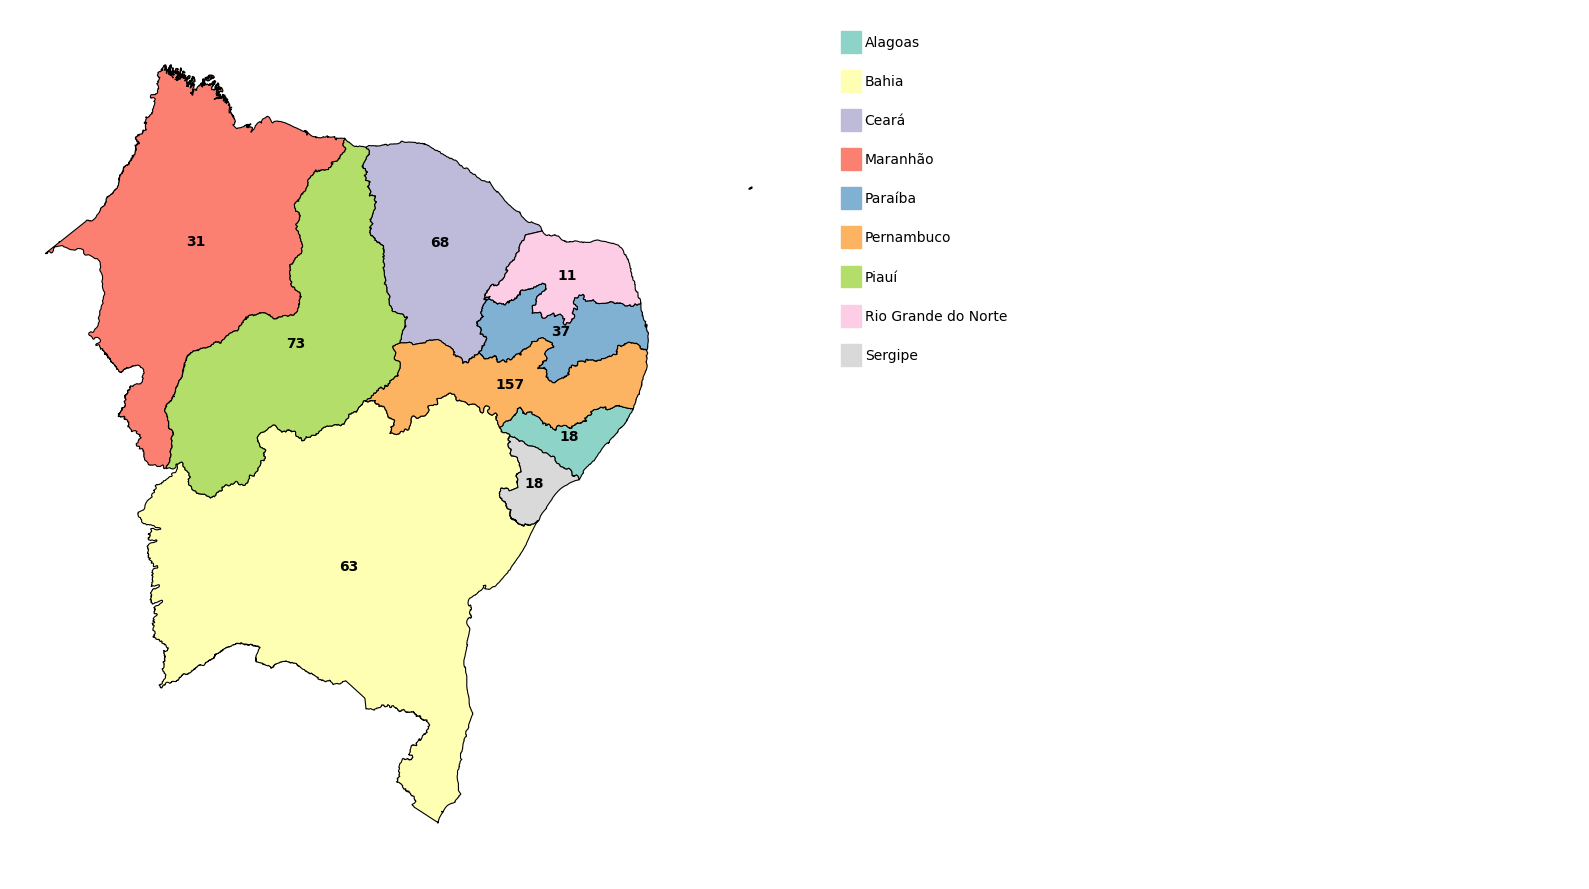

In [19]:
# 1. Load data
df = pd.read_csv('./data/completed/brazilian_ne_annotated_humorous_texts.csv')

# 2. Count annotations per state
state_counts = df['brazilian_state'].value_counts().reset_index()
state_counts.columns = ['brazilian_state', 'annotation_count']

# 3. List of Northeast states
northeast_states = [
    'Alagoas', 'Bahia', 'Ceará', 'Maranhão', 'Paraíba',
    'Pernambuco', 'Piauí', 'Rio Grande do Norte', 'Sergipe'
]

# 4. Filter to only Northeast
state_counts = state_counts[state_counts['brazilian_state'].isin(northeast_states)]

# 5. Load Brazil state geometries
states = gpd.read_file('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson')

# 6. Filter only Northeast states
northeast_map = states[states['name'].isin(northeast_states)].copy()

# 7. Merge geometry with annotation counts
northeast_map = northeast_map.merge(state_counts, left_on='name', right_on='brazilian_state')

# 8. Assign distinct colors per state
palette = sns.color_palette("Set3", len(northeast_map))
state_colors = {state: mcolors.to_hex(palette[i]) for i, state in enumerate(northeast_map['name'])}
northeast_map['color'] = northeast_map['name'].map(state_colors)

# 9. Plot map using full GeoDataFrame
fig, ax = plt.subplots(1, 2, figsize=(16, 9))

# Plot full GeoDataFrame with custom colors
northeast_map.plot(
    ax=ax[0],
    color=northeast_map['color'],
    edgecolor='black',
    linewidth=0.8
)

# Add annotation count inside each state using centroid
for idx, row in northeast_map.iterrows():
    centroid = row['geometry'].centroid
    ax[0].text(centroid.x, centroid.y, str(row['annotation_count']),
               fontsize=10, ha='center', va='center', color='black', weight='bold')

#ax[0].set_title('Annotated Texts by State (Northeast Brazil)', fontsize=14)
ax[0].axis('off')

# 10. Build the legend manually (name-color table)
ax[1].axis('off')
legend_table = pd.DataFrame({
    'State': northeast_map['name'],
    'Color': northeast_map['color']
}).sort_values('State').reset_index(drop=True)

# 🔧 Adjust size/spacing parameters
box_width = 0.025   # smaller color box
box_height = 0.025
start_y = 0.95
line_spacing = 0.045  # tighter spacing

# Draw smaller colored boxes and closer text
for i, row in legend_table.iterrows():
    y = start_y - i * line_spacing
    ax[1].add_patch(mpatches.Rectangle((0.05, y), box_width, box_height,
                                       color=row['Color'], transform=ax[1].transAxes, clip_on=False))
    ax[1].text(0.08, y + box_height / 2, row['State'],
               transform=ax[1].transAxes, fontsize=10, va='center')

plt.savefig('northeastern_map_highres.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()